In [1]:
%matplotlib widget
import pystare
import numpy
import geopandas
import starepandas
import pandas
import matplotlib.pyplot as plt
import cartopy.crs
import sqlalchemy
import contextily

In [2]:
n_workers = 600

# Get all sids

In [3]:
def get_sids(level):
    level_increment = pystare.spatial_increment_from_level(level)
    n_trixels = 8 * (4 ** level)
    r_ = numpy.arange(n_trixels)
    sids = r_ * level_increment+level    
    return sids

In [4]:
sids = numpy.array([3458764513820540928])
df = starepandas.STAREDataFrame(sids=sids)
df.trixel_grings()

array([[[ 0.14644661,  0.85355339,  0.49999999],
        [-0.85355339, -0.14644661,  0.49999999],
        [ 0.49999999, -0.49999999,  0.70710679]]])

# Building DF Cache

In [40]:
level = 2
sids = get_sids(level)
df = starepandas.STAREDataFrame(sids=sids)
df.add_trixels(n_partitions=1, inplace=True)

In [41]:
df['hex'] = df.hex()
df['level'] = level

df['centers'] = df.trixel_centers().tolist()
df['centers_ecef'] = df.trixel_centers_ecef().tolist()
df['center_points'] = df.trixel_centerpoints()

df['corners'] = df.trixel_corners().tolist()
df['corners_ecef'] = df.trixel_corners_ecef().tolist()

df['grings'] = df.trixel_grings().tolist()

<GeoAxesSubplot:>

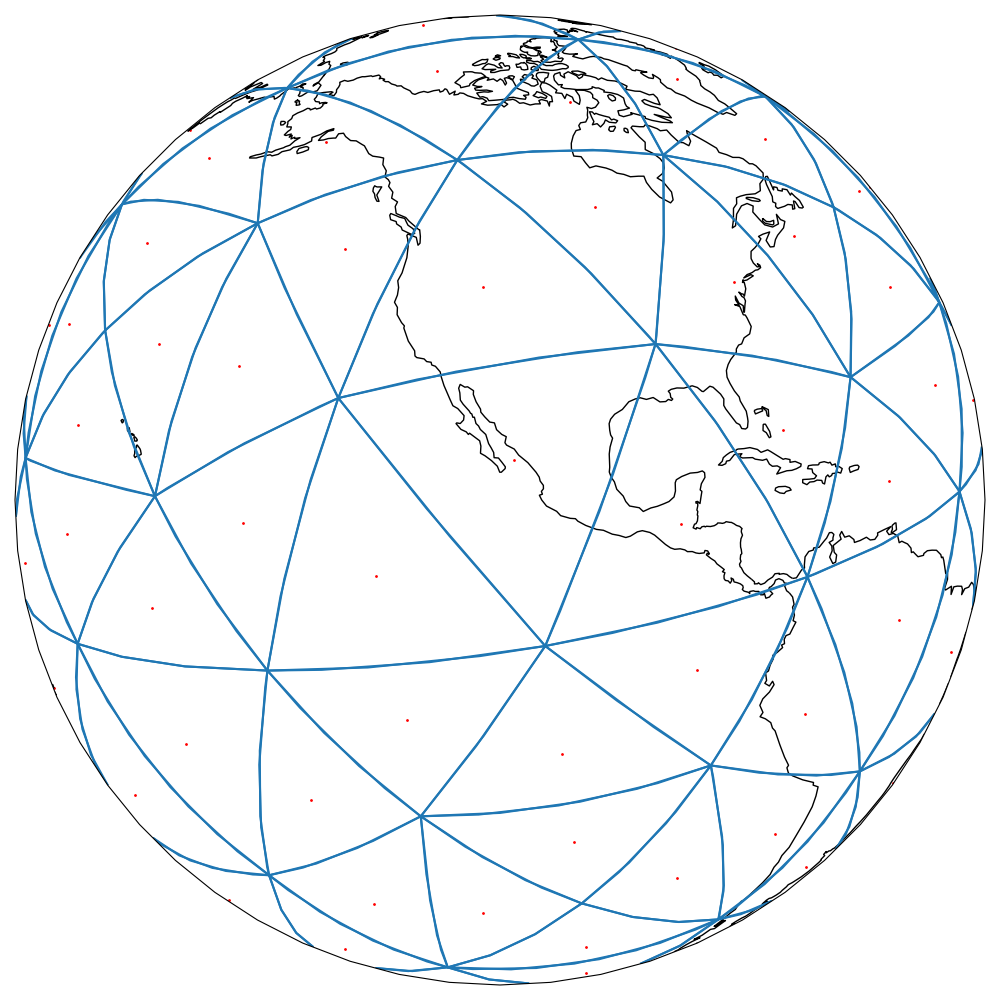

In [42]:
proj = cartopy.crs.NearsidePerspective(central_longitude=-110.0, 
                                       central_latitude=20, 
                                       satellite_height=35785831, 
                                       false_easting=0, 
                                       false_northing=0, globe=None)

#proj=cartopy.crs.Sinusoidal()
proj._threshold = proj._threshold/20.
opts = {'projection': proj}

fig, ax = plt.subplots(figsize=(10,10), dpi=100, subplot_kw=opts)
fig.tight_layout()

ax.coastlines()
#ax.stock_img()

transf = cartopy.crs.Geodetic()


df['trixels'].boundary.plot(ax=ax, transform=transf)
df.set_geometry('center_points').plot(ax=ax, color='r',
                                      boundary=False, trixels=False, 
                                      markersize=1, transform=transf)

#ax.outline_patch.set_visible(False)
#ax.background_patch.set_visible(False)

#fig.savefig('L4.png', facecolor=fig.get_facecolor(), transparent=True)

# SQL Cache 
DataFrame with one field per Value

In [30]:
level = 6
sids = get_sids(level)
df = starepandas.STAREDataFrame(sids=sids)

## Subsetting to geographical region (Optional)

In [31]:
gdf = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
africa = gdf[gdf['continent'] == 'Africa']
africa = africa.dissolve().iloc[0].geometry

sids_area = starepandas.sids_from_shapely(africa, resolution=level, force_ccw=True)
intersects = df.stare_intersects(sids_area, n_workers=n_workers)
df = df[intersects]

## Make Trixels

In [32]:
trixels = df.make_trixels(n_workers=n_workers)
df.set_trixels(trixels, inplace=True)

## Make vertices

In [33]:
vertices = df.trixel_vertices()

## Make (shapely) Centerpoints 

In [34]:
df['center_points'] = df.trixel_centerpoints(vertices)

## Plot

<GeoAxesSubplot:>

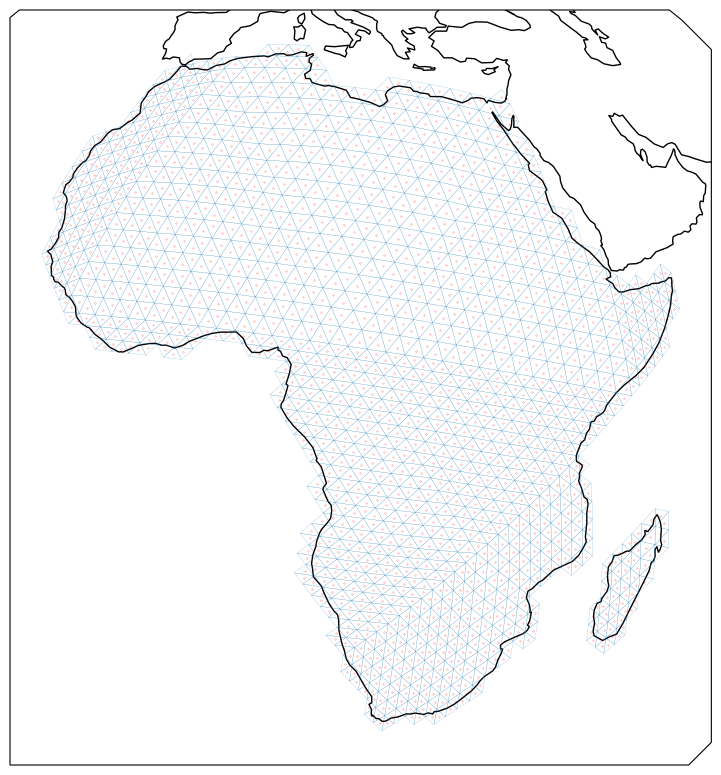

In [35]:
fig, ax = plt.subplots(figsize=(10, 10), dpi=100, subplot_kw=opts)
ax.coastlines()

transf = cartopy.crs.Geodetic()
df.plot(ax=ax, trixels=True, transform=transf, lw=0.1)

df.set_geometry('center_points').plot(ax=ax, color='r',
                                      boundary=False, trixels=False, marker='.',
                                      markersize=0.1, transform=transf)

## Make Hex and Level and area

In [36]:
df['hex'] = df.hex()
df['level'] = level

f = (6371)**2
df['sterdians'] =  pystare.to_area(df.sids) 
df['area'] = df['sterdians'] * f

## Creating a Dataframe for each 
- Centers (lat/lon + ECEF) 
- Corners (lat/lon + ECEF)
- Edges

In [37]:
centers = pandas.DataFrame(df.trixel_centers(vertices), 
                           columns={'center_lon', 'center_lat'}, index=df.sids)

centers_ecef = pandas.DataFrame(df.trixel_centers_ecef(vertices), 
                                columns={'x', 'y', 'z'}, index=df.sids).add_prefix('center_')

In [38]:
corners = df.trixel_corners(vertices).transpose(1, 0, 2)

corners1 = pandas.DataFrame(corners[0], 
                            columns=['lon', 'lat'], index=df.sids).add_prefix('corner1_')

corners2 = pandas.DataFrame(corners[1], 
                            columns=['lon', 'lat'], index=df.sids).add_prefix('corner2_')

corners3 = pandas.DataFrame(corners[2], 
                            columns=['lon', 'lat'], index=df.sids).add_prefix('corner3_')

corners = corners1.join(corners2).join(corners3)

In [39]:
corners_ecef = df.trixel_corners_ecef(vertices).transpose(1, 0, 2)

corners_ecef1 = pandas.DataFrame(corners_ecef[0], 
                             columns=['x', 'y', 'z'], index=df.sids).add_prefix('corner1_')

corners_ecef2 = pandas.DataFrame(corners_ecef[1], 
                             columns=['x', 'y', 'z'], index=df.sids).add_prefix('corner2_')

corners_ecef3 = pandas.DataFrame(corners_ecef[2], 
                             columns=['x', 'y', 'z'], index=df.sids).add_prefix('corner3_')

corners_ecef = corners_ecef1.join(corners_ecef2).join(corners_ecef3)

In [40]:
grings = df.trixel_grings(vertices).transpose(1, 0, 2)

edge1 = pandas.DataFrame(grings[0],
                         columns=['x', 'y', 'z'], index=df.sids).add_prefix('edge1_')

edge2 = pandas.DataFrame(grings[0],
                         columns=['x', 'y', 'z'], index=df.sids).add_prefix('edge2_')

edge3 = pandas.DataFrame(grings[0],
                         columns=['x', 'y', 'z'], index=df.sids).add_prefix('edge3_')

edges = edge1.join(edge2).join(edge3)

# Writing out to separate geopackage layers

In [41]:
df.set_index('sids', inplace=True)

In [42]:
fname = 'cache.gpkg'
engine = sqlalchemy.create_engine('sqlite:///{}'.format(fname))

t = df[['trixels']].set_geometry('trixels', crs='EPSG:4326')
t.to_file(fname, layer='trixels_{:0>2d}'.format(level), driver='GPKG')

c = df[['center_points']].set_geometry('center_points', crs='EPSG:4326')
c.to_file(fname, layer='centers_{:0>2d}'.format(level), driver='GPKG')

df[['hex', 'level', 'sterdians', 'area']].to_sql(name='info_{:0>2d}'.format(level), 
                                                 con=engine,
                                                 if_exists='replace')

centers.to_sql(name='latlon_{:0>2d}'.format(level), con=engine, if_exists='replace')

1955

## Joining the 5 dataframes

In [43]:
df = df.join(centers).join(centers_ecef).join(corners).join(corners_ecef).join(edges)

## Now serializing/converting the WKT to eWKB so we can upload to SQL

In [44]:
# Those are odd functions; 
# https://github.com/geopandas/geopandas/blob/8c7845401171b96755e3facf9b241730f373483a/geopandas/io/sql.py#L274
df = geopandas.io.sql._convert_to_ewkb(df, 'trixels', 4326)
df = geopandas.io.sql._convert_to_ewkb(df, 'center_points', 4326)

In [45]:
engine = sqlalchemy.create_engine('sqlite:///cache.sqlite')
df.to_sql('level_{:0>2d}'.format(level), con=engine, if_exists='replace')

1955

In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1955 entries, 2814749767106566 to 4611545280939032582
Data columns (total 35 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   trixels        1955 non-null   object 
 1   center_points  1955 non-null   object 
 2   hex            1955 non-null   object 
 3   level          1955 non-null   int64  
 4   sterdians      1955 non-null   float64
 5   area           1955 non-null   float64
 6   center_lon     1955 non-null   float64
 7   center_lat     1955 non-null   float64
 8   center_z       1955 non-null   float64
 9   center_x       1955 non-null   float64
 10  center_y       1955 non-null   float64
 11  corner1_lon    1955 non-null   float64
 12  corner1_lat    1955 non-null   float64
 13  corner2_lon    1955 non-null   float64
 14  corner2_lat    1955 non-null   float64
 15  corner3_lon    1955 non-null   float64
 16  corner3_lat    1955 non-null   float64
 17  corner1_x      1955 no